# About

This program downloads, manages, and exports to .csv files inflation forecast data from the Federal Reserve Bank of Philadelphia, and actual inflation and interest rate data from FRED. The purpose is to learn about historical *ex ante* real interest rates in the US.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
from fredpy import series, window_equalize, toFredSeries
import datetime,dateutil,urllib,runProcs
import requests

# Import forecast data

In [2]:
# url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/inflation.xls?la=en"
# r = requests.get(url,verify=False)
# with open("inflationForecasts.xls", "wb") as code:
#     code.write(r.content)
    
url = "https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/historical-data/medianlevel.xls?la=en"
r = requests.get(url,verify=False)
with open("../xls/medianLevel.xls", "wb") as code:
    code.write(r.content)

/Users/bcjenkin/anaconda/lib/python3.4/site-packages/requests/packages/urllib3/connectionpool.py:821: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


In [3]:
# inflationForecasts = pd.read_excel('inflationForecasts.xls')
# inflationForecasts=inflationForecasts.interpolate()
# # inflationForecasts.iloc[0:5]

In [4]:
deflatorForecasts = pd.read_excel('../xls/medianLevel.xls',sheetname = 'PGDP')
deflatorForecasts=deflatorForecasts.interpolate()
deflatorForecasts = deflatorForecasts.iloc[5:]
# deflatorForecasts.iloc[0:5]

In [5]:
# cpiForecasts = pd.read_excel('medianLevel.xls',sheetname = 'CPI')
# cpiForecasts = cpiForecasts.iloc[5:]
# cpiForecasts=cpiForecasts.interpolate()
# # cpiForecasts.iloc[0:5]

## GDP deflator inflation forecasts

In [6]:
# Create some fredpy instances
defl_forecast_1q = series('GDPDEF')
defl_forecast_2q = series('GDPDEF')
defl_forecast_1y = series('GDPDEF')

# Initialize forecast lists
forecast_1q = []
forecast_2q = []
forecast_1y = []

# Associate forecasts with dates. The date should coincide with the start of the period for which the forecast applies.
dates = []
for i,ind in enumerate(deflatorForecasts.index):
    year =int(deflatorForecasts.iloc[i]['YEAR'])
    quart=int(deflatorForecasts.iloc[i]['QUARTER'])
    if quart == 1:
        month = '01'
    elif quart == 2:
        month = '04'
    elif quart == 3:
        month = '07'
    else:
        month = '10'
        year=year
    date = month+'-01-'+str(year)
    dates.append(date)
    
    forecast_1q.append(400*(deflatorForecasts.iloc[i]['PGDP3']/deflatorForecasts.iloc[i]['PGDP2']-1))
    forecast_2q.append(200*(deflatorForecasts.iloc[i]['PGDP4']/deflatorForecasts.iloc[i]['PGDP2']-1))
    forecast_1y.append(100*(deflatorForecasts.iloc[i]['PGDP6']/deflatorForecasts.iloc[i]['PGDP2']-1))
    
dateNumbers = [dateutil.parser.parse(s) for s in dates]

# Update the FRED instances
defl_forecast_1q.data = np.array(forecast_1q)
defl_forecast_1q.dates = dates
defl_forecast_1q.datenumbers = dateNumbers

defl_forecast_2q.data = np.array(forecast_2q)
defl_forecast_2q.dates = dates
defl_forecast_2q.datenumbers = dateNumbers

defl_forecast_1y.data = np.array(forecast_1y)
defl_forecast_1y.dates = dates
defl_forecast_1y.datenumbers = dateNumbers

deflator_frame = pd.DataFrame({'deflator inflation - 3mo forecast':defl_forecast_1q.data,
                          'deflator inflation - 6mo forecast':defl_forecast_2q.data,
                          'deflator inflation - 1yr forecast':defl_forecast_1y.data,})

deflator_frame = deflator_frame.set_index(pd.DatetimeIndex(defl_forecast_1q.datenumbers))

## Actual data

In [7]:
interest3mo = series('TB3MS')
interest6mo = series('TB6MS')
interest1yr = series('GS1')

interest3mo.monthtoquarter()
interest6mo.monthtoquarter()
interest1yr.monthtoquarter()

window_equalize([interest3mo,interest6mo,interest1yr])

interest_frame = pd.DataFrame({'nominal interest - 3mo':interest3mo.data,
                             'nominal interest - 6mo':interest6mo.data,
                             'nominal interest - 1yr':interest1yr.data})
interest_frame = interest_frame.set_index(pd.DatetimeIndex(interest3mo.datenumbers))

In [8]:
defl_3mo = series('GDPDEF')
defl_6mo = series('GDPDEF')
defl_1yr = series('GDPDEF')

defl_3mo.pc(method='forward',annualized=True)

data = []
for i in range(len(defl_6mo.data)-2):
    data.append(200*(defl_6mo.data[i+2]/defl_6mo.data[i]-1))
    
defl_6mo.data = np.array(data)  
defl_6mo.dates = defl_6mo.dates[:-2]
defl_6mo.datenumbers = defl_6mo.datenumbers[:-2]


data = []
for i in range(len(defl_1yr.data)-4):
    data.append(100*(defl_1yr.data[i+4]/defl_1yr.data[i]-1))
    
defl_1yr.data = np.array(data)  
defl_1yr.dates = defl_1yr.dates[:-4]
defl_1yr.datenumbers = defl_1yr.datenumbers[:-4]

defl_3mo_frame = pd.DataFrame({'deflator inflation - 3mo actual':defl_3mo.data})
defl_3mo_frame = defl_3mo_frame.set_index(pd.DatetimeIndex(defl_3mo.datenumbers))

defl_6mo_frame = pd.DataFrame({'deflator inflation - 6mo actual':defl_6mo.data})
defl_6mo_frame = defl_6mo_frame.set_index(pd.DatetimeIndex(defl_6mo.datenumbers))

defl_1yr_frame = pd.DataFrame({'deflator inflation - 1yr actual':defl_1yr.data})
defl_1yr_frame = defl_1yr_frame.set_index(pd.DatetimeIndex(defl_1yr.datenumbers))

In [9]:
actual_rates_frame = pd.concat([interest_frame,defl_3mo_frame,defl_6mo_frame,defl_1yr_frame],axis = 1)

## Organize actual and forecasted data and export to csv files

In [10]:
full_data_frame = pd.concat([actual_rates_frame,deflator_frame],axis=1)
full_data_frame = full_data_frame.dropna(subset=['deflator inflation - 1yr forecast',
                                                 'deflator inflation - 3mo forecast',
                                                 'deflator inflation - 6mo forecast'])

In [11]:
# Export quarterly data
full_data_frame[['deflator inflation - 3mo forecast','deflator inflation - 3mo actual','nominal interest - 3mo'
                ]].to_csv('../csv/realRateDataQ.csv')

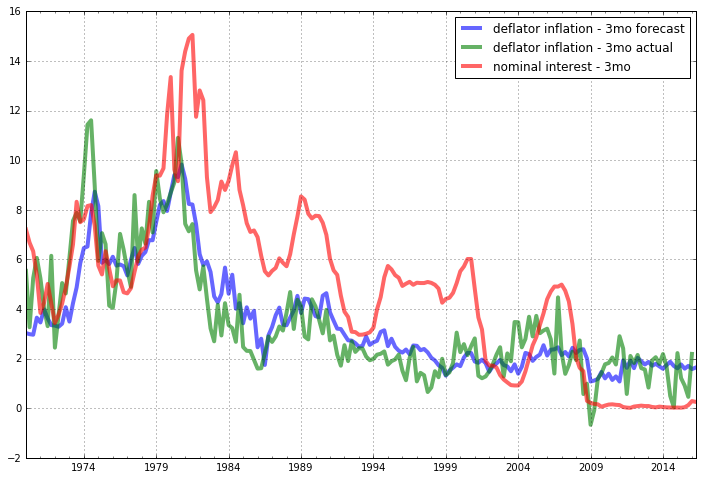

In [12]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
full_data_frame[['deflator inflation - 3mo forecast','deflator inflation - 3mo actual','nominal interest - 3mo'
                ]].plot(ax=ax,lw=4,alpha = 0.6,grid=True)

In [13]:
# Construct annual data and export

# Resample to annual freq and count occurences per year
annual_data_frame = full_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','nominal interest - 1yr'
                ]].resample('AS', how=[np.mean,pd.Series.count])

# drop years with less than 4 quarters interest or inflation forecast 
annual_data_frame = annual_data_frame[(annual_data_frame['deflator inflation - 1yr forecast']['count'] == 4) & 
                 (annual_data_frame['nominal interest - 1yr']['count'] == 4)]

# Drop the count  columns and multilevel index
annual_data_frame = annual_data_frame.iloc[:, annual_data_frame.columns.get_level_values(1)=='mean']
annual_data_frame.columns = annual_data_frame.columns.droplevel(level = 1)

# Export to csv
annual_data_frame[['deflator inflation - 1yr forecast','deflator inflation - 1yr actual','nominal interest - 1yr'
                ]].to_csv('../csv/realRateDataA.csv')

/Users/bcjenkin/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


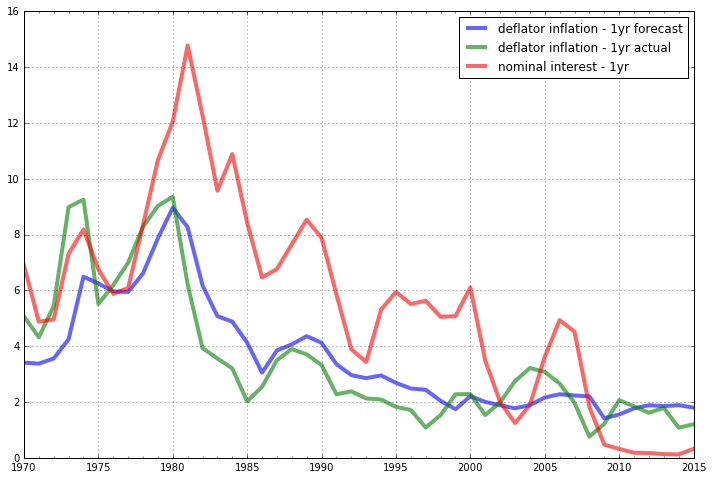

In [14]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1)
annual_data_frame.plot(ax=ax,lw=4,alpha = 0.6,grid=True)

## Figure for website

In [15]:
# Formatter for inserting commas in y axis labels with magnitudes in the thousands

# Make all plotted axis lables and tick lables bold 15 pt font
font = {#'weight' : 'bold',
        'size'   : 15}
axes={'labelweight' : 'bold'}
plt.rc('font', **font)
plt.rc('axes', **axes)

# Add some space around the tick lables for better readability
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'


def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = plt.FuncFormatter(func)  # make formatter

# format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


# y label locator for vertical axes plotting gdp
majorLocator_y   = plt.MultipleLocator(3)
majorLocator_shares   = plt.MultipleLocator(0.2)

# Index locator
def findDateIndex(dateStr,fredObj):
    for n,d in enumerate(fredObj.dates):
        if d == dateStr:
            return n

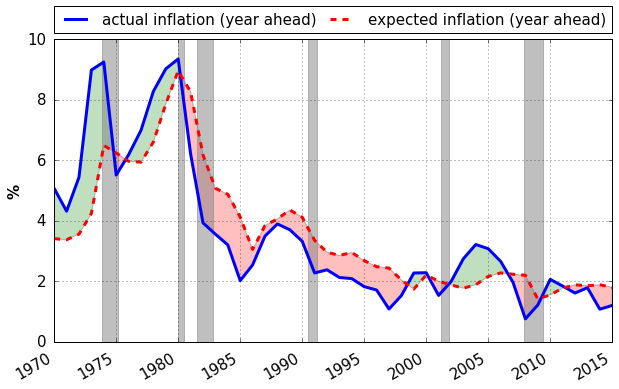

In [16]:
# Figure

expectedInflation = annual_data_frame['deflator inflation - 1yr forecast']
actualInflation = annual_data_frame['deflator inflation - 1yr actual']

u =series('UNRATE')
v =toFredSeries(annual_data_frame['deflator inflation - 1yr actual'].values,annual_data_frame['deflator inflation - 1yr actual'].index,pandasDates=True)
window_equalize([u,v])


fig=plt.figure(figsize=(10, 6))
ax=fig.add_subplot(1,1,1)
u.recessions()
ax.plot_date(annual_data_frame.index,actualInflation,'b-',lw=3)
ax.plot_date(annual_data_frame.index,expectedInflation,'r--',lw=3)
ax.fill_between(annual_data_frame.index,actualInflation, expectedInflation, where = expectedInflation<actualInflation,alpha=0.25,facecolor='green', interpolate=True)
ax.fill_between(annual_data_frame.index,actualInflation, expectedInflation, where = expectedInflation>actualInflation,alpha=0.25,facecolor='red', interpolate=True)
# ax.set_title('Actual and Expected Inflation')
ax.set_ylabel('%')
ax.xaxis.set_major_locator(years5)
ax.legend(['actual inflation (year ahead)','expected inflation (year ahead)'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,prop={'weight':'normal','size':'15'})
plt.grid()
fig.autofmt_xdate()
plt.savefig('../img/fig_US_Inflation_Forecast_site.png',bbox_inches='tight')

In [17]:
progName = 'realRateData'
runProcs.exportNb(progName)